In [6]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split


In [7]:
#差分方程  # 生成数据
def nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1):
    # 生成噪声
    noise_level = 0.01
    noise1 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    noise2 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    # 计算输出
    output1 = y1_k / (1 + y2_k**2) + u1_k + 0.2 * u2_k + 0.4 * u1_k_1 + 0.1 * u2_k_1 + noise1
    output2 = y1_k * y2_k / (1 + y2_k**2) + 0.3 * u1_k + u2_k + 0.1 * u1_k_1 + 0.5 * u2_k_1 + noise2
    return output1, output2


# 参数设置
num_samples = 300
y1_data, y2_data = np.zeros(num_samples), np.zeros(num_samples)

# 初始化初始条件
y1_data[0], y2_data[0] = 1.0, 0.5

# 生成输入数据在[-1, 1]之间
u1_data = np.random.uniform(-1, 1, num_samples)
u2_data = np.random.uniform(-1, 1, num_samples)
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0  # 设置第一个时刻的上一个时刻输入为0

# 生成数据
for k in range(1, num_samples):
    y1_data[k], y2_data[k] = nonlinear_system(y1_data[k-1], y2_data[k-1], u1_data[k], u2_data[k], u1_data_1[k], u2_data_1[k])



In [8]:
# 组合训练数据  多输入单输出
# 假设有训练数据 u1_data, u2_data, y1_data_1 和 y1_data
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0
y1_data_1 = np.roll(y1_data, 1)
y1_data_1[0] = 0.3
X = np.column_stack((u1_data, u2_data, u1_data_1, u2_data_1, y1_data_1))
y = y1_data
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state=42)
# print(X.shape)
# print(y.shape)

# print(X_train.shape)
# print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)



In [9]:
# 组合训练数据  多输入双输出
# 构成训练数据，假设X{u1_data、u2_data、u1_data_1、u2_data_2、y1_data_1、y2_data_1 } 是输入特征，Y{y1_data} 是输出标签
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0  # 设置第一个时刻的上一个时刻输入为0
y1_data_1 = np.roll(y1_data, 1)
y2_data_1 = np.roll(y2_data, 1)
y1_data_1[0], y2_data_1[0] = 0.5, 0.5  # 设置第一个时刻的上一个时刻输入为0.5
X = np.column_stack((u1_data, u2_data, u1_data_1, u2_data_1, y1_data_1, y2_data_1))
y = np.column_stack((y1_data,y2_data))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state=42)


In [32]:
# 获取模型参数
def get_params(W_b):

    mid_indix = W_b.shape[0]//2-1
    pred_0 = W_b[-2:-1]
    W0 = W_b[:mid_indix]
    b1 = W_b[-1:]
    W1 = W_b[mid_indix:mid_indix*2]
    W_b_0 = np.concatenate((W0, pred_0))
    W_b_1 = np.concatenate((W1, b1))
    # print(mid_indix)

    # print('pred_0:',pred_0.shape)
    # print('W0:',W0.shape)
    # print('b1:',b1.shape)
    # print('W1:',W1.shape)
    return pred_0,W0,b1,W1,W_b_0,W_b_1


In [66]:
# 定义My_M_LS_SVRModel
class My_M_LS_SVRModel:
    def __init__(self, params):
        # print(params)
        self.C0 = params[0]
        self.C1 = params[1]
        self.C00 = params[2]
        self.gamma = params[3]
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y, C0, C1, C00): 
            b0,W0,b1,W1,W_b_0,W_b_1 = get_params(W_b)

            y_pred_0 = np.dot(K_train, W0) + b0
            y_pred_1 = np.dot(K_train, W1) + b1
            # print(X.shape)
            # print(y.shape)
            errors0 = y[:,0] - y_pred_0
            errors1 = y[:,1] - y_pred_1

            # 损失函数
            loss = ( 0.5 * (np.dot(W0, W0)+np.dot(W1, W1)) 
                    + C0 * np.sum(errors0**2) + C1 * np.sum(errors1**2)
                    # + C00 * np.sum(np.sqrt(errors0**2 + errors1**2)) # L2 范数
                    + C00 * np.sum(errors0**2 + errors1**2) # L2 范数的平方
                    )
            return loss

        # 初始化权重向量+偏移项b
        initial_W_b = np.zeros((X_train.shape[0]+1)*2)
        
        # 使用minimize 函数最小化目标函数
        result = minimize(objective, initial_W_b, args=(X_train, y_train, self.C0, self.C1, self.C00),
                            method='L-BFGS-B')
        # print(result)
        # 输出最优的权重向量
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        b0,W0,b1,W1,W_b_0,W_b_1 = get_params(self.W_b)
        y_pred_0 = np.dot(K_test, W0) + b0
        y_pred_1 = np.dot(K_test, W1) + b1

        return y_pred_0,y_pred_1
    



# # 示例用法
# params = [16.46138798 23.71780845 64.62895219  0.12096073]
# # 创建模型
# my_svr_model = My_M_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred_0,y_pred_1 = my_svr_model.predict(X_test)


In [54]:
# 优化次数
Particle_num = 20
iterations_max=10



In [67]:
# 使用粒子群优化
def initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax):
    # 初始化粒子群的位置和速度
    positions = np.random.uniform(Xmin, Xmax, size=(Particle_num, params_num))
    # plt.plot(positions[:,0],positions[:,1])
    velocities = np.random.uniform(Vmin, Vmax, size=(Particle_num, params_num))
    return positions, velocities
def evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test):
    # 在这里计算适应值（均方根误差）
    fitness_values = your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test)
    return fitness_values
def update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values):
    # 对每个粒子进行循环
    for i in range(len(positions)):
        # 如果当前适应值更好，则更新个体最佳位置和适应值
        if fitness_values[i] < personal_best_fitness[i]:
            personal_best_positions[i] = positions[i].copy()
            personal_best_fitness[i] = fitness_values[i]
    return personal_best_positions, personal_best_fitness
def update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness):
    # 找到所有粒子中适应值最好的粒子的索引
    best_particle_index = np.argmin(personal_best_fitness)
    # 如果该粒子的适应值更好，则更新全局最佳位置和适应值
    if personal_best_fitness[best_particle_index] < global_best_fitness:
        global_best_position[:] = personal_best_positions[best_particle_index].copy()
        global_best_fitness = personal_best_fitness[best_particle_index]
    return global_best_position,global_best_fitness
def update_particles(iteration, iterations_max, positions, velocities, personal_best_positions, global_best_position, 
                    c1, c2, Xmin, Xmax, Vmin, Vmax):
    # 更新粒子的速度和位置
    r1 = np.random.rand(*positions.shape)
    r2 = np.random.rand(*positions.shape)
    

    w_max = 0.9
    w_min = 0.4
    weight = w_max - iteration*(w_max-w_min)/iterations_max
    # weight = 1
    velocities = weight * velocities + c1 * r1 * (personal_best_positions - positions) + c2 * r2 * (global_best_position - positions)
    # 限制速度范围
    velocities = np.clip(velocities, Vmin, Vmax)
    # 更新位置
    positions = positions + velocities
    # 限制位置范围
    positions = np.clip(positions, Xmin, Xmax)

    return positions, velocities
def pso_algorithm(Particle_num, Xmin, Xmax, Vmin, Vmax, iterations_max, params_num, C1, C2, tao, X_train, y_train, X_test, y_test):
    # 初始化粒子群
    positions, velocities = initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax)

    # 初始化每个粒子的个体最佳位置和适应值
    personal_best_positions = positions.copy()
    personal_best_fitness = np.full(Particle_num, np.inf)#所有元素的值都设置为正无穷
    
    # 初始化全局最佳位置和适应值
    global_best_position = np.zeros(params_num)
    global_best_fitness = np.inf

    fitness_values = np.zeros(Particle_num)
    # 开始迭代
    fitness_values_list = []  # 用于存储每次迭代后的最佳适应值
    for iteration in range(iterations_max):
        print('iteration',iteration)
        # 计算每个粒子的适应值
        fitness_values = evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test)
        
        # 更新个体最佳位置和适应值
        personal_best_positions, personal_best_fitness = update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values)
        
        # 更新全局最佳位置和适应值
        global_best_position,global_best_fitness = update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness)
        print(global_best_position,global_best_fitness)
        # 更新粒子的速度和位置
        positions, velocities = update_particles(iteration, iterations_max,positions, velocities, personal_best_positions, global_best_position, C1, C2, Xmin, Xmax, Vmin, Vmax)
        
        # 记录适应度值
        fitness_values_list.append(global_best_fitness)
        
        # 检查收敛精度
        if global_best_fitness < tao:
            break

    # 返回最终的全局最佳位置和适应值
    return global_best_position, global_best_fitness, fitness_values_list
# 替换为你实际的目标函数
def your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test):
    for i in range(len(positions)):
        print('i',i)
        # 示例用法
        params = positions[i]
        # 创建模型
        my_svr_model = My_M_LS_SVRModel(params)
        # 训练模型
        my_svr_model.fit(X_train, y_train)
        # 模型预测
        y_pred_0,y_pred_1 = my_svr_model.predict(X_test)
        errors0 = y_test[:,0] - y_pred_0
        errors1 = y_test[:,1] - y_pred_1
        # 在这里计算适应值函数
        mse = np.sqrt(np.sum(errors0**2+errors1**2)/X_test.shape[0])     
        print(mse)      
        fitness_values[i] = mse
    return fitness_values

# position = [C0, C1, C00 ,gamma]
# 调用粒子群算法
vel = 1
result_position, result_fitness, fitness_values_list = pso_algorithm(Particle_num = Particle_num, Xmin=0, Xmax=100, Vmin=-vel, Vmax=vel, 
                                                iterations_max=iterations_max, params_num = 4, C1=2, C2=2, tao=0.1, 
                                                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
# 输出结果
print(f"Global Best Position: {result_position}")
print(f"Global Best Fitness: {result_fitness}")


params = result_position
# 创建模型
my_svr_model = My_M_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_train, y_train)
# 模型预测
y_pred_0,y_pred_1 = my_svr_model.predict(X_test)




# 1.345s



iteration 0
i 0
[19.34324699 94.9727198  77.01077562 75.52274471]
1.1366760376161875
i 1
[12.23942797 64.7100089  12.89108478  2.8126345 ]
0.7328842124900542
i 2
[50.1985759  80.48298311 10.61162767 80.90630115]
1.1368846517047881
i 3
[15.74383391 93.77170758  6.99995886 90.33292542]
1.1371625967227506
i 4
[40.02983858 19.75534417 20.78388469 77.96025292]
1.136778085382742
i 5
[71.90076827  4.09144774 86.00471009 99.60349074]
1.1373422079939475
i 6
[42.04567561 62.71380391 55.92020765 17.28674334]
1.1164997306866953
i 7
[64.57819926 69.74707107 12.1082954  84.38647243]
1.1369959065226847
i 8
[78.36386396  8.75557531 82.37500402 23.87476721]
1.1261854550928991
i 9
[14.241922   92.34586122 76.57995017 38.26745984]
1.1327631186276825
i 10
[26.46433782 93.31468867 98.05843643 75.42405254]
1.1366706429254558
i 11
[33.97094925  9.27651658 69.78325489 41.21309312]
1.1333990915835235
i 12
[67.96702073 40.07623581 13.54269136 50.94246939]
1.134866581308408
i 13
[21.69607987 14.15596619 14.65771

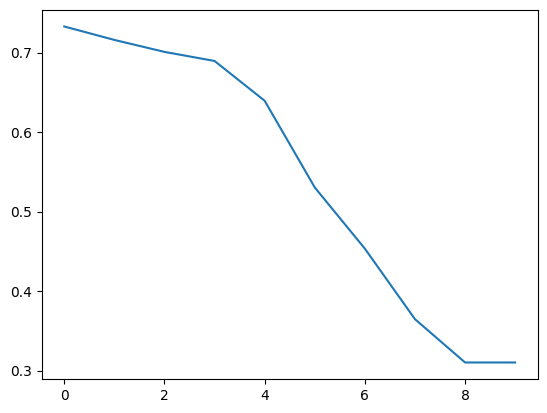

In [68]:
plt.plot(fitness_values_list)


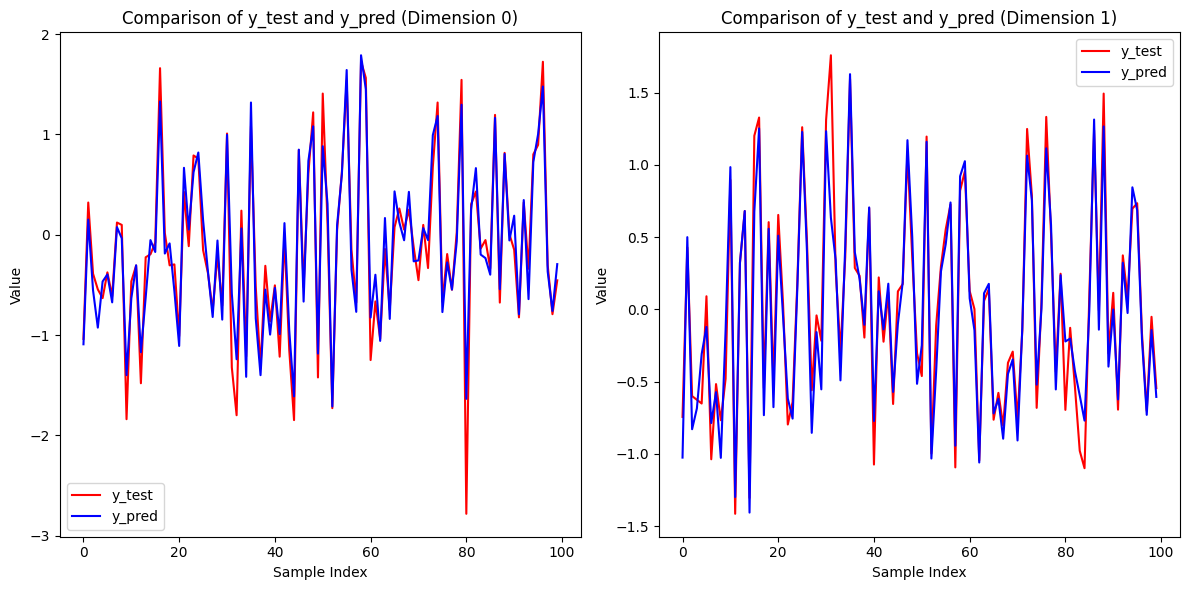

In [69]:
# 自定义优化结果
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 6))

# 第一个维度的曲线
plt.subplot(1, 2, 1)
plt.plot(y_test[:, 0], 'r-', label='y_test')
plt.plot(y_pred_0, 'b-', label='y_pred')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 0)')
plt.legend()

# 第二个维度的曲线
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 1], 'r-', label='y_test')
plt.plot(y_pred_1, 'b-', label='y_pred')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 1)')
plt.legend()

# 调整子图布局
plt.tight_layout()
plt.show()


In [70]:
# keras mul_SVR 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假设 X 包含 u1_data、u2_data、y1_data_1、y2_data_1
# Y 包含 y1_data、y2_data
# 请确保 X 和 Y 的形状匹配

# 定义优化目标函数
def objective(params):
    C, gamma = params
    svr = SVR(kernel='rbf', C=C, gamma=gamma)
    multioutput_svr = MultiOutputRegressor(svr)  # 使用MultiOutputRegressor包装SVR
    multioutput_svr.fit(X_train, y_train)
    y_pred = multioutput_svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    # mse = np.sum(np.sqrt(np.sum((y_test-y_pred)**2, axis=1)))
    return mse

# 定义参数搜索空间
# 定义参数搜索空间
space = [(0.1, 200.0, 'log-uniform'),  # C范围为[0.1, 100]的对数均匀分布
        (0.001, 10.0, 'log-uniform')]  # gamma范围为[0.01, 10]的对数均匀分布

# 使用粒子群算法进行参数优化
result = gp_minimize(objective, space, n_calls=20, random_state=42)

# 输出最优参数
best_params = result.x
print(f"Best Parameters (C, gamma): {best_params}")

# 在最优参数下重新训练模型
best_C, best_gamma = best_params
best_svr = SVR(kernel='rbf', C=best_C, gamma=1)
multioutput_best_svr = MultiOutputRegressor(best_svr)
multioutput_best_svr.fit(X_train, y_train)

# 在测试集上进行预测
y_pred222 = multioutput_best_svr.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred222)
# mse = np.sum(np.sqrt(np.sum((y_test-y_pred)**2, axis=1)))

print(f'Mean Squared Error with Optimized Parameters: {mse}')


Best Parameters (C, gamma): [200.0, 0.02043741702185689]
Mean Squared Error with Optimized Parameters: 0.09701707826703185


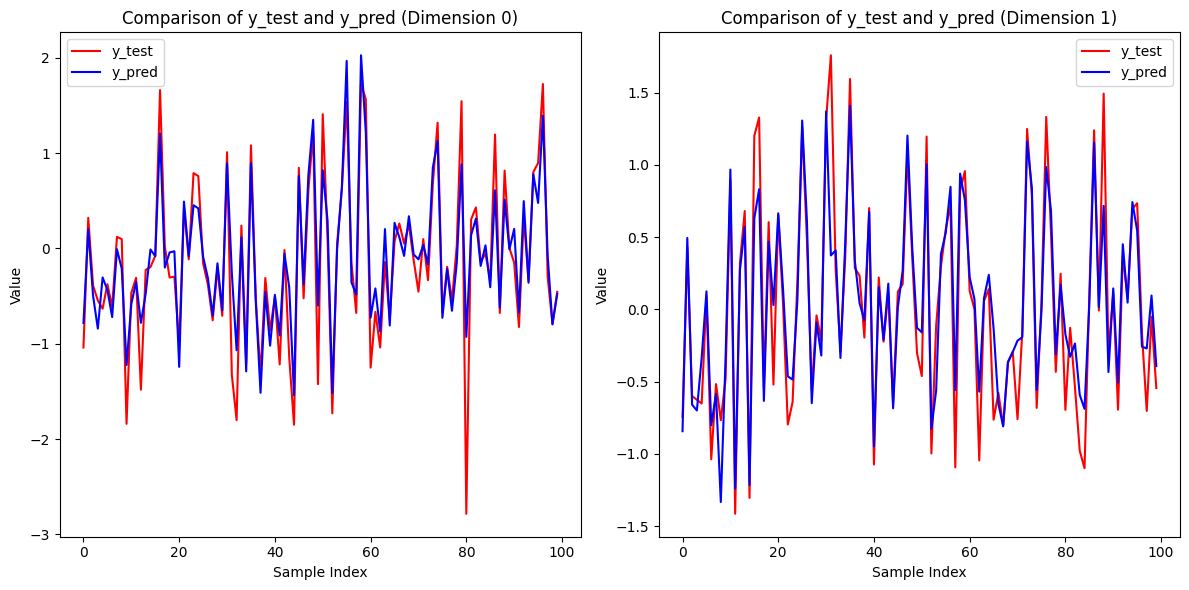

In [71]:
# keras结果
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 6))

# 第一个维度的曲线
plt.subplot(1, 2, 1)
plt.plot(y_test[:, 0], 'r-', label='y_test')
plt.plot(y_pred222[:,0], 'b-', label='y_pred')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 0)')
plt.legend()

# 第二个维度的曲线
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 1], 'r-', label='y_test')
plt.plot(y_pred222[:,1], 'b-', label='y_pred')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 1)')
plt.legend()

# 调整子图布局
plt.tight_layout()
plt.show()


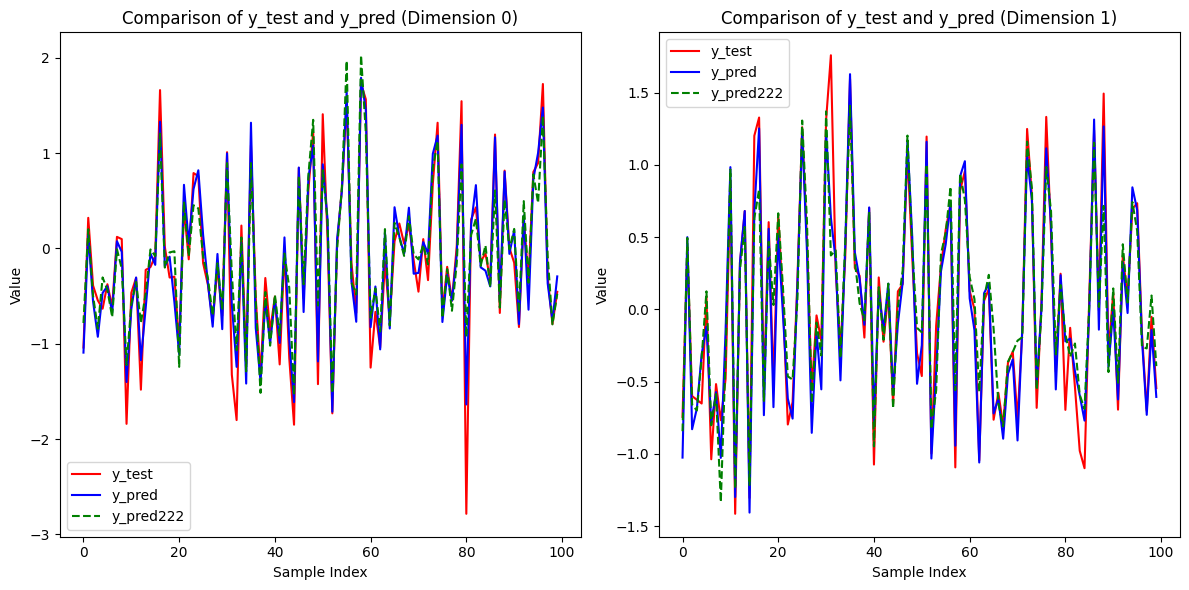

In [72]:
# 三种信号对比

plt.figure(figsize=(12, 6))

# 第一个维度的曲线
plt.subplot(1, 2, 1)
plt.plot(y_test[:, 0], 'r-', label='y_test')
plt.plot(y_pred_0, 'b-', label='y_pred')
plt.plot(y_pred222[:,0],'g--', label='y_pred222')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 0)')
plt.legend()

# 第二个维度的曲线
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 1], 'r-', label='y_test')
plt.plot(y_pred_1, 'b-', label='y_pred')
plt.plot(y_pred222[:,1],'g--', label='y_pred222')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 1)')
plt.legend()

# 调整子图布局
plt.tight_layout()
plt.show()


MSE(pred_0, test_0): 0.057646022155551695
MSE(pred222_0, test_0): 0.12035759470088886
MSE(pred_1, test_1): 0.03855702827781709
MSE(pred222_1, test_1): 0.07367656183317477


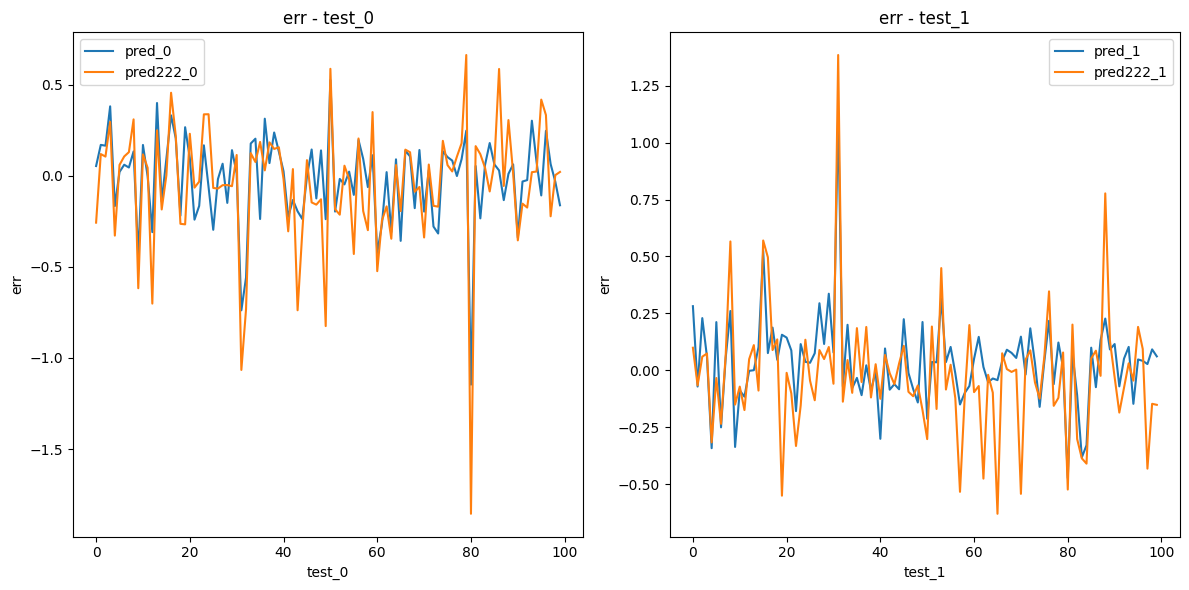

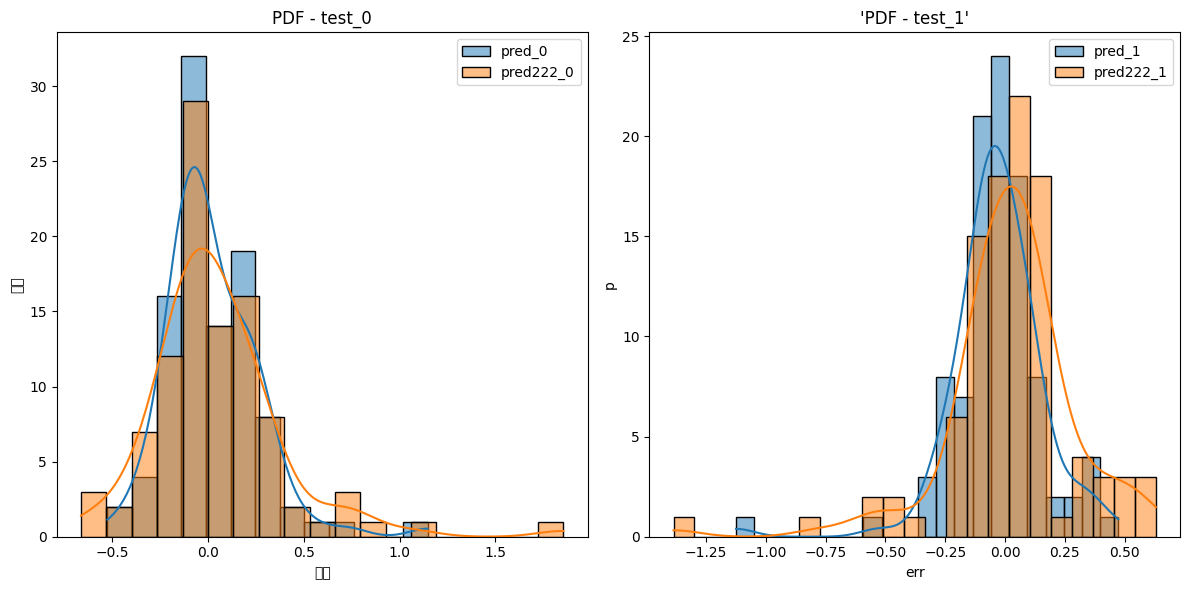

In [73]:
# 均方误差、误差分布图、误差概率密度函数（PDF）图
test_0 = y_test[:,0]
pred_0 = y_pred_0
pred222_0 = y_pred222[:,0]

test_1 = y_test[:,1]
pred_1 = y_pred_1
pred222_1 = y_pred222[:,1]



# 计算 b 对 a 的均方误差
mse_pred_0 = mean_squared_error(test_0, pred_0)
print(f'MSE(pred_0, test_0): {mse_pred_0}')
# 计算 c 对 a 的均方误差
mse_pred222_0 = mean_squared_error(test_0, pred222_0)
print(f'MSE(pred222_0, test_0): {mse_pred222_0}')
# 计算 b 对 a 的均方误差
mse_pred_1 = mean_squared_error(test_1, pred_1)
print(f'MSE(pred_1, test_1): {mse_pred_1}')
# 计算 c 对 a 的均方误差
mse_pred222_1 = mean_squared_error(test_1, pred222_1)
print(f'MSE(pred222_1, test_1): {mse_pred222_1}')



import matplotlib.pyplot as plt
import seaborn as sns

# 误差分布图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(test_0-pred_0, label='pred_0')
plt.plot(test_0-pred222_0, label='pred222_0')
plt.xlabel('test_0')
plt.ylabel('err')
plt.title('err - test_0')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_1-pred_1, label='pred_1')
plt.plot(test_1-pred222_1, label='pred222_1')
plt.xlabel('test_1')
plt.ylabel('err')
plt.title('err - test_1')
plt.legend()

plt.tight_layout()
plt.show()

# 误差概率密度函数（PDF）图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(pred_0 - test_0, kde=True, label='pred_0')
sns.histplot(pred222_0 - test_0, kde=True, label='pred222_0')
plt.xlabel('误差')
plt.ylabel('频率')
plt.title('PDF - test_0')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(pred_1 - test_1, kde=True, label='pred_1')
sns.histplot(pred222_1 - test_1, kde=True, label='pred222_1')
plt.xlabel('err')
plt.ylabel('p')
plt.title("'PDF - test_1'")
plt.legend()

plt.tight_layout()
plt.show()


In [74]:
import numpy as np
from sklearn.svm import SVR
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 生成示例数据
# 这里假设你有一个包含输入和输出数据的数组 X 和 Y
# X = {u1(k), u2(k), u1(k-1), u2(k-1), y(k)}
# Y = {y(k+1)}


# 假设已经有LS-SVR模型的参数
# params = [5.33993953e+01 ,3.32226485e-02]
params = result_position
# 创建模型
my_svr_model = My_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_train, y_train)


NameError: name 'My_LS_SVRModel' is not defined